Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

In [860]:
%%capture

import sys
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as lr
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'


# Module Project: Logistic Regression

Do you like burritos? 🌯 You're in luck then, because in this project you'll create a model to predict whether a burrito is `'Great'`.

The dataset for this assignment comes from [Scott Cole](https://srcole.github.io/100burritos/), a San Diego-based data scientist and burrito enthusiast. 

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function .
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build `model_logr` using a pipeline that includes three transfomers and `LogisticRegression` predictor. Train model on `X_train` and `X_test`.
- **Task 7:** Calculate the training and test accuracy score for your model.
- **Task 8:** Create a horizontal bar chart showing the 10 most influencial features for your  model. 
- **Task 9:** Demonstrate and explain the differences between `model_lr.predict()` and `model_lr.predict_proba()`.

**Note** 

You should limit yourself to the following libraries:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

# I. Wrangle Data

In [861]:

def wrangle(filepath):
    # Import w/ DateTimeIndex
    df = pd.read_csv(filepath, parse_dates=['Date'],
                     index_col='Date')

    # Drop unrated burritos
    df.dropna(subset=['overall'], inplace=True)

    # Derive binary classification target:
    # We define a 'Great' burrito as having an
    # overall rating of 4 or higher, on a 5 point scale
    df['Great'] = (df['overall'] >= 4).astype(int)

    # Drop high cardinality categoricals
    df = df.drop(columns=['Notes', 'Location',
                 'Address', 'URL', 'Neighborhood'])

    # Drop columns to prevent "leakage"
    df = df.drop(columns=['Rec', 'overall'])
    df = df.drop(columns=['Queso'])
    return df


filepath = DATA_PATH + 'burritos/burritos.csv'


**Task 1:** Use the above `wrangle` function to import the `burritos.csv` file into a DataFrame named `df`.

In [862]:
filepath = DATA_PATH + 'burritos/burritos.csv'
df = wrangle(filepath)


During your exploratory data analysis, note that there are several columns whose data type is `object` but that seem to be a binary encoding. For example, `df['Beef'].head()` returns:

```
0      x
1      x
2    NaN
3      x
4      x
Name: Beef, dtype: object
```

**Task 2:** Change the `wrangle` function so that these columns are properly encoded as `0` and `1`s. Be sure your code handles upper- and lowercase `X`s, and `NaN`s.

In [863]:
def encode(df):
    list = ['x', 'X', 'Yes', 'No']
    dict = {'x': '1', 'X': '1', 'Yes': '1', 'No': '0'}
    if any(x in df.value_counts().index.to_list() for x in list):
        df = df.map(dict)
        df = df.fillna(0)
    return df


df = df.apply(encode)


In [874]:
# Conduct your exploratory data analysis here
# And modify the `wrangle` function above.

#making sure I cleaned up all null valls
for col in df:
    if df[col].notnull().sum() != len(df):
        if(df[col].dtype != ('float64' or 'int64')):
            print(df[col].name)

Reviewer


If you explore the `'Burrito'` column of `df`, you'll notice that it's a high-cardinality categorical feature. You'll also notice that there's a lot of overlap between the categories. 

**Stretch Goal:** Change the `wrangle` function above so that it engineers four new features: `'california'`, `'asada'`, `'surf'`, and `'carnitas'`. Each row should have a `1` or `0` based on the text information in the `'Burrito'` column. For example, here's how the first 5 rows of the dataset would look.

| **Burrito** | **california** | **asada** | **surf** | **carnitas** |
| :---------- | :------------: | :-------: | :------: | :----------: |
| California  |       1        |     0     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |
|  Carnitas   |       0        |     0     |    0     |      1       |
| Carne asada |       0        |     1     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |

**Note:** Be sure to also drop the `'Burrito'` once you've engineered your new features.

In [865]:
# Conduct your exploratory data analysis here
# And modify the `wrangle` function above.

df.loc[df['Burrito'] == 'California', 'california'] = 1
df.loc[df['Burrito'] != 'California', 'california'] = 0
df['california'] = df['california'].astype(int)


df.loc[df['Burrito'] == 'Carnitas', 'carnitas'] = 1
df.loc[df['Burrito'] != 'Carnitas', 'carnitas'] = 0
df['carnitas'] = df['carnitas'].astype(int)

df.loc[df['Burrito'] == 'Carne asada', 'asada'] = 1
df.loc[df['Burrito'] != 'Carne asada', 'asada'] = 0
df['asada'] = df['asada'].astype(int)

df.loc[df['Burrito'].str.contains('surf', case=False),'surf'] = 1
df['surf'] = df['surf'].fillna(0)
df['surf'] = df['surf'].astype(int)


#pd.set_option("display.max_rows", None, "display.max_columns", None)
#df['Burrito'].value_counts()

df.drop(columns='Burrito', inplace=True)


# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'Great'`.

In [866]:
X = df.drop(columns=['Great'])
y = df['Great']

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from 2016 through 2017. 
- Your test set should include data from 2018 and later.

In [867]:
train = (X.index.year <= 2017) & (X.index.year >= 2016)
test = X.index.year >= 2018
X_train, y_train = X[train], y[train]
X_test, y_test = X[test], y[test]

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents. 

In [868]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)


Baseline Accuracy Score: 0.5826771653543307


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_logr`, and fit it to your training data. Your pipeline should include:

- a `OneHotEncoder` transformer for categorical features, 
- a `SimpleImputer` transformer to deal with missing values, 
- a [`StandarScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) transfomer (which often improves performance in a logistic regression model), and 
- a `LogisticRegression` predictor.

In [869]:
model_logr = make_pipeline(OneHotEncoder(use_cat_names=True), SimpleImputer(
    strategy='mean'), StandardScaler(), lr())

model_logr.fit(X_train, y_train)


C:\Users\coco\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Chips', 'Reviewer', 'Unreliable', 'NonSD',
                                     'Beef', 'Pico', 'Guac', 'Cheese', 'Fries',
                                     'Sour cream', 'Pork', 'Chicken', 'Shrimp',
                                     'Fish', 'Rice', 'Beans', 'Lettuce',
                                     'Tomato', 'Bell peper', 'Carrots',
                                     'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro',
                                     'Onion', 'Taquito', 'Pineapple', 'Ham',
                                     'Chile relleno', 'Nopales', ...],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

# IV. Check Metrics

**Task 7:** Calculate the training and test accuracy score for `model_lr`.

In [883]:
training_acc = model_logr.score(X_train, y_train)
test_acc = model_logr.score(X_test,y_test)
print('Training MAE:', training_acc)
print('Test MAE:', test_acc)


Training MAE: 0.9711286089238845
Test MAE: 0.7894736842105263


# V. Communicate Results

**Task 8:** Create a horizontal barchart that plots the 10 most important coefficients for `model_lr`, sorted by absolute value.

**Note:** Since you created your model using a `Pipeline`, you'll need to use the [`named_steps`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) attribute to access the coefficients in your `LogisticRegression` predictor. Be sure to look at the shape of the coefficients array before you combine it with the feature names.

<AxesSubplot:>

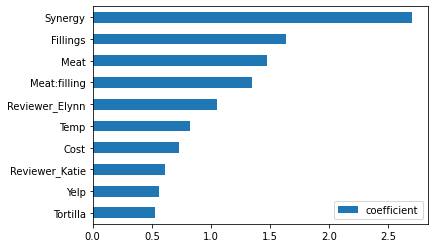

In [871]:
pd.DataFrame(data=model_logr['logisticregression'].coef_.reshape(-1,
             1), columns=['coefficient'], index=model_logr[0].get_feature_names()).abs().sort_values(by='coefficient').tail(10).plot(kind='barh')
# Create your horizontal barchart here.


There is more than one way to generate predictions with `model_lr`. For instance, you can use [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression) or [`predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression.predict_proba).

**Task 9:** Generate predictions for `X_test` using both `predict` and `predict_proba`. Then below, write a summary of the differences in the output for these two methods. You should answer the following questions:

- What data type do `predict` and `predict_proba` output?
- What are the shapes of their different output?
- What numerical values are in the output?
- What do those numerical values represent?

In [887]:
# Write code here to explore the differences between `predict` and `predict_proba`.
predict = model_logr.predict(X_train)
predict_proba = model_logr.predict_proba(X_test)

# percent of great burritos.
predict.sum() / len(predict)

0.4041994750656168

**Give your written answer here:**

```
predict returns a np.array that predicts whether the burrito was great(1) or not(0). its shape should be the length of the training set

predict_proba returns a np.array with the probability of whether or not the data belongs to class 0(not Great) to class 1(Great burrito). its shape should be two dimensional.
```